In [1]:
!pip install pandas numpy matplotlib statsmodels scikit-learn scipy



[notice] A new release of pip is available: 24.0 -> 25.1
[notice] To update, run: C:\Users\Wal_S\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


In [62]:
!pip install arch

   ---------------------------------------- 0.0/927.1 kB ? eta -:--:--
   ---------------------------------------- 10.2/927.1 kB ? eta -:--:--
   -- ------------------------------------ 61.4/927.1 kB 812.7 kB/s eta 0:00:02
   -------------- ------------------------- 337.9/927.1 kB 3.0 MB/s eta 0:00:01
   ---------------------------------------- 927.1/927.1 kB 5.9 MB/s eta 0:00:00



[notice] A new release of pip is available: 24.0 -> 25.1.1
[notice] To update, run: C:\Users\Wal_S\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


In [75]:
!pip install --upgrade statsmodels



[notice] A new release of pip is available: 24.0 -> 25.1.1
[notice] To update, run: C:\Users\Wal_S\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


In [122]:
# Core libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Time series decomposition
from statsmodels.tsa.seasonal import seasonal_decompose, STL

# Time series diagnostics
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# Spectral analysis
from scipy.signal import periodogram

# Other
from sklearn.linear_model import LinearRegression

# Plotting style
plt.style.use('seaborn-v0_8-whitegrid')

# Color mapping for plots
colours = {
    'cucumbers': 'palegreen',
    'guitars': 'peru',
    'slingshots': 'violet',
    'stocks': 'tomato',
    'sugar': 'palegoldenrod',
    'water': 'skyblue',
    'tranquillity': 'pink'
}


In [123]:
import numpy as np
import pandas as pd
from scipy.stats import boxcox, boxcox_llf
from statsmodels.tsa.seasonal import STL
from statsmodels.stats.diagnostic import acorr_ljungbox

# ─── your cleaning steps ─────────────────────────
df = pd.read_csv('spiff_data.csv')
df.rename(columns={'gurkor':'cucumbers'}, inplace=True)
df = df.loc[:, ~df.columns.str.contains('^Unnamed')]
mask = df.columns != 'day'
df.loc[:, mask] = df.loc[:, mask].replace(1000.0, np.nan)
df['day'] = pd.to_datetime(df['day'], errors='coerce')

# print(df.head(1000))
# if len(df) >= 1000:
#     print("✔️  1000th row’s day is:", df.loc[999, 'day'])
# else:
#     print("❗ DataFrame has fewer than 1000 rows.")

# ─── build a ts‑friendly copy ─────────────────────
df_ts = df.copy().set_index('day').sort_index()

seasonal_period = 7
results = []

for col in df_ts.columns:
    y      = df_ts[col]
    non_na = y.dropna()
    shift  = max(0, 1 - non_na.min())

    # 1) Box–Cox λ̂
    bc_dat = non_na + shift
    _, lam = boxcox(bc_dat)
    lam2   = round(lam, 2)

    # 2) Log‑likelihood at λ̂  <- fixed argument order here
    llf = boxcox_llf(lam, bc_dat)

    # 3) Prepare interpolated series for STL
    y_add = y.interpolate('time')
    y_log = np.log(y.add(shift)).interpolate('time')

    # 4) Additive STL
    stl_add = STL(y_add, period=seasonal_period, robust=True).fit()
    rmse_add = np.sqrt(np.nanmean(stl_add.resid**2))

    # 5) “Multiplicative” STL via log
    stl_log = STL(y_log, period=seasonal_period, robust=True).fit()
    rmse_log = np.sqrt(np.nanmean(stl_log.resid**2))

    # 6) RMSE ratio
    ratio = rmse_add / rmse_log

    # 7) Ljung–Box on additive residuals, lags = s and 2s
    lb = acorr_ljungbox(stl_add.resid, lags=[seasonal_period, 2*seasonal_period], return_df=True)
    q_s, p_s   = lb.loc[seasonal_period, ['lb_stat','lb_pvalue']]
    q_2s, p_2s = lb.loc[2*seasonal_period, ['lb_stat','lb_pvalue']]

    results.append({
        'series':       col,
        'lambdâ':      lam2,
        'loglik':       llf,
        'rmse_add':     rmse_add,
        'rmse_log':     rmse_log,
        'ratio':        ratio,
        'LB Q(s)':      q_s,
        'LB p(s)':      p_s,
        'LB Q(2s)':     q_2s,
        'LB p(2s)':     p_2s,
        'preferred':    'additive' if rmse_add < rmse_log else 'multiplicative'
    })

df_results = pd.DataFrame(results).set_index('series')
print(df_results)



              lambdâ     loglik  rmse_add  rmse_log    ratio    LB Q(s)  \
series                                                                     
cucumbers       -0.99 -3755.4481    0.0408    0.0043   9.5948  3041.0090   
guitars          0.57 -2884.9139    0.1102    0.0180   6.1375  3876.6799   
slingshots      -0.02   335.7025    0.0637    0.0174   3.6635  3168.1714   
stocks          -2.05 -2129.8213    0.1225    0.0154   7.9260  3505.6258   
sugar            0.22  1749.1965    0.0418    0.0165   2.5335  2712.6098   
water            0.01 -1126.1033    0.0253    0.0040   6.3201  3515.6842   
tranquillity    -0.79 -5302.3334    0.2000    0.0141  14.1464  4122.8336   

              LB p(s)   LB Q(2s)  LB p(2s)       preferred  
series                                                      
cucumbers         0.0  3248.4130       0.0  multiplicative  
guitars           0.0  4329.8190       0.0  multiplicative  
slingshots        0.0  3367.5954       0.0  multiplicative  
stocks    

In [124]:
print("\nFirst 10 raw 'day' strings:")
print(df["day"].head(10).tolist())

print("\nNumber of non-NaT dates after to_datetime:")
tmp = pd.to_datetime(df["day"], errors="coerce")
print(tmp.notna().sum(), " / ", len(tmp))

print("\nUnique day-of-month values in the good dates:")
print(pd.Series(tmp.dropna().dt.day).unique()[:10])



First 10 raw 'day' strings:
[Timestamp('1970-01-01 00:00:00.000000001'), Timestamp('1970-01-01 00:00:00.000000002'), Timestamp('1970-01-01 00:00:00.000000003'), Timestamp('1970-01-01 00:00:00.000000004'), Timestamp('1970-01-01 00:00:00.000000005'), Timestamp('1970-01-01 00:00:00.000000006'), Timestamp('1970-01-01 00:00:00.000000007'), Timestamp('1970-01-01 00:00:00.000000008'), Timestamp('1970-01-01 00:00:00.000000009'), Timestamp('1970-01-01 00:00:00.000000010')]

Number of non-NaT dates after to_datetime:
5456  /  5456

Unique day-of-month values in the good dates:
[1]


In [102]:
# 1.  Read & clean CSV ----------------------------------------------------
df = pd.read_csv("spiff_data.csv")
df.rename(columns={"gurkor": "cucumbers"}, inplace=True)
df = df.loc[:, ~df.columns.str.contains(r"^Unnamed", na=False)]

#      1000.0 placeholders -> NaN  (every data column)
df[df.columns.difference(["day"])] = df[df.columns.difference(["day"])].replace(1000.0, np.nan)

# 2.  Parse the "day" column *as day numbers* -----------------------------
#     (0 = 1970-01-01, 1 = 1970-01-02, …)
df["day"] = pd.to_datetime(df["day"], unit="D", origin="unix")

# 3.  Build a strictly daily index ---------------------------------------
df_ts = (
    df.set_index("day")
      .sort_index()     # ascending
      .asfreq("D")      # inserts one NaN row for every missing calendar date
)
print(df_ts.index.freq)          # → <Day>
print(len(df_ts))                # → 5 456


<Day>
5456


In [125]:
def manual_detrend(series, window):
    """Detrends a series using centered moving average smoothing."""
    trend = series.rolling(window=window, center=True, min_periods=1).mean()
    detrended = series - trend
    return detrended, trend


In [126]:
# Periodogram Plotting
def plot_periodogram(detrended_series, title=''):
    """Plots periodogram to detect dominant periods in a detrended series."""
    f, Pxx = periodogram(detrended_series.dropna())
    periods = 1 / f
    plt.figure(figsize=(12, 4))
    plt.plot(periods, Pxx)
    plt.xlim(0, 400)  # Adjust based on data range
    plt.title(f'Periodogram {title}')
    plt.xlabel('Period (Days)')
    plt.ylabel('Spectral Power')
    plt.grid(True)
    plt.show()


In [129]:
def plot_fft(detrended_series, title=''):
    """Plots FFT amplitude spectrum to validate dominant periods."""
    fft_vals = np.fft.fft(detrended_series.dropna())
    fft_freqs = np.fft.fftfreq(len(fft_vals))
    pos_freqs = fft_freqs[fft_freqs > 0]
    fft_magnitudes = np.abs(fft_vals)[fft_freqs > 0]
    periods = 1 / pos_freqs

    plt.figure(figsize=(12, 4))
    plt.plot(periods, fft_magnitudes)
    plt.xlim(0, 400)
    plt.title(f'FFT Spectrum {title}')
    plt.xlabel('Period (Days)')
    plt.ylabel('Amplitude')
    plt.grid(True)
    plt.show()


In [88]:
import os
from pathlib import Path

# 1) What’s my current working directory?
print("CWD:", os.getcwd())

# 2) What files are there?
print("Files:", os.listdir())

# 3) Does my CSV exist?
print("spiff_data.csv exists →", Path('spiff_data.csv').is_file())


CWD: c:\Users\Wal_S\time-series
Files: ['.git', '.gitignore', '.venv', 'analysis_over_series.ipynb', 'code_pontus.ipynb', 'Code_Veronica.ipynb', 'Crosscorr_logreturns.ipynb', 'project.pdf', 'spiff_data.csv']
spiff_data.csv exists → True


In [8]:
def stl_on_detrended(detrended_series, period):
    """Applies STL decomposition on a detrended series."""
    stl = STL(detrended_series.dropna(), period=period, robust=True)
    result = stl.fit()
    return result


Flat LS spectrum – no seasonal peak.


NameError: name 'peaks' is not defined

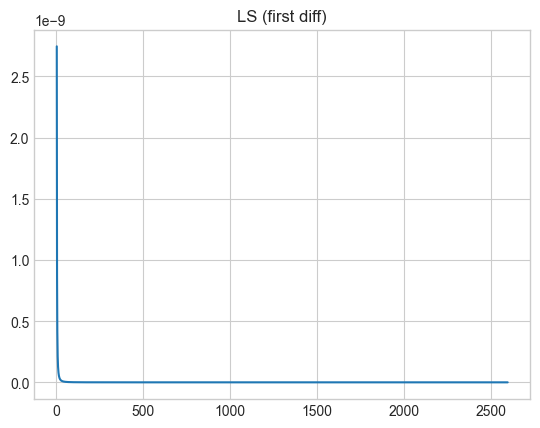

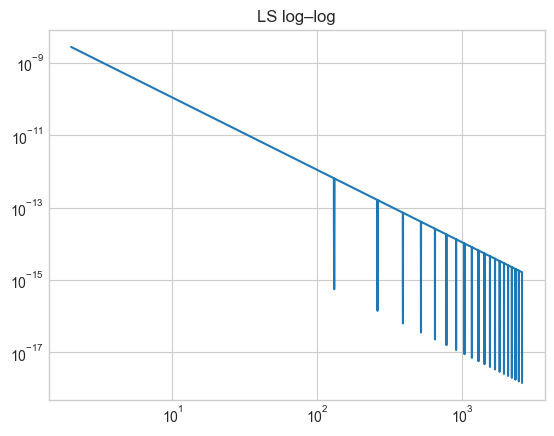

In [133]:
import numpy as np, matplotlib.pyplot as plt
from scipy.signal import lombscargle
from statsmodels.graphics.tsaplots import plot_acf

# -------------------- CONFIG --------------------
SERIES_NAME    = "cucumbers"
DETREND_METHOD = "diff"          # "diff" or "ma"
MA_WINDOW      = 7               # used only if DETREND_METHOD == "ma"
PERIOD_RANGE   = (1, 5000)         # search band (days)
# ------------------------------------------------

y = df_ts[SERIES_NAME]
log_y = np.log(y)

# 1 ─ detrend
if DETREND_METHOD == "diff":
    resid = log_y.diff()
    label = "first diff"
else:
    trend = log_y.rolling(MA_WINDOW, center=True, min_periods=1).mean()
    resid = log_y - trend
    label = f"MA({MA_WINDOW})"
resid = resid.dropna()

if len(resid) < 3:
    print(f"{SERIES_NAME}: <3 residual points → skip LS/ACF.")
else:
    # 2 ─ Lomb–Scargle
    t = (resid.index.astype("int64") - resid.index.astype("int64").min()) / 8.64e13
    y0 = resid.values - resid.values.mean()

    per_min = max(PERIOD_RANGE[0], 2)
    per_max = min(PERIOD_RANGE[1], len(resid)//2)
    periods = np.linspace(per_min, per_max, 5_000)
    freqs   = 1/periods
    power   = lombscargle(t, y0, 2*np.pi*freqs, precenter=True, normalize=True)

    if np.allclose(power, power[0]):
        print("Flat LS spectrum – no seasonal peak.")
    else:
        peaks   = periods[np.argsort(power)[-3:][::-1]]
        print("Top-3 candidate periods (d):", peaks.round(2))

    # 3 ─ plots
    plt.figure(); plt.plot(periods, power); plt.title(f"LS ({label})"); plt.grid(True)
    plt.figure(); plt.loglog(periods, power); plt.title("LS log–log"); plt.grid(True)

    max_lag = min(int(peaks[0]*4), 120, len(resid)-1) if not np.isnan(peaks[0]) else 0
    if max_lag >= 1:
        plt.figure(); plot_acf(resid, lags=max_lag); plt.title("ACF"); plt.tight_layout()



<Figure size 640x480 with 0 Axes>

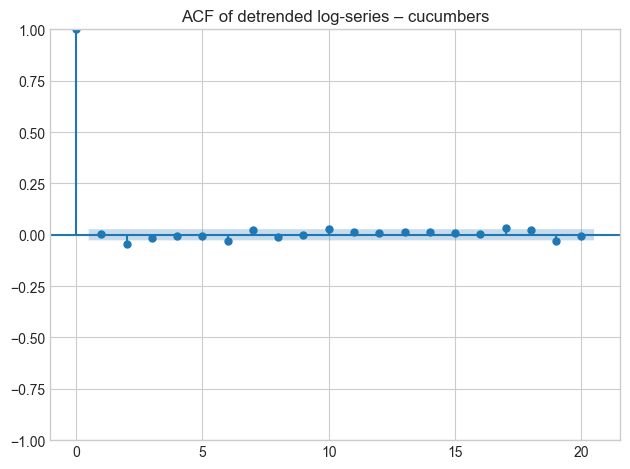

In [134]:
# --- ACF plot ----------------------------------------------------
if "peaks" in locals() and not np.isnan(peaks[0]):          # peak exists
    max_lag = min(int(peaks[0]*4), 120, len(resid)-1)
else:                                                      # flat spectrum
    max_lag = min(20, len(resid)-1)                        # ← new line

if max_lag >= 1:
    plt.figure()
    plot_acf(resid, lags=max_lag)
    plt.title(f"ACF of detrended log-series – {SERIES_NAME}")
    plt.tight_layout()
else:
    print("Residual series too short for meaningful ACF plot.")


In [135]:
series = df_ts[SERIES_NAME]

print("Original length   :", len(series))
print("Positive count    :", (series > 0).sum())
print("1000 placeholders :", (series == 1000).sum())
print("NaNs              :", series.isna().sum())


Original length   : 5456
Positive count    : 5201
1000 placeholders : 0
NaNs              : 255


In [ ]:
import numpy as np, pandas as pd, statsmodels.api as sm
from scipy.stats import boxcox_normmax
from statsmodels.tsa.seasonal import STL
from statsmodels.tsa.forecasting.utils import guerrero

#This snippet is used to formalize the box-cox test with 95CI using guerro (robust for different sesonalities)
#I can't run this because I have troubles with the guerro import, but this is crucial so we can say with 95% 
#certainity that the raw data is multiplicative 

SERIES_NAME    = "cucumbers"
s              = 7                 # season length you found via LS/ACF

# 0 ── pull the series as a pandas Series
y = df_ts[SERIES_NAME]

# 1 ── Box-Cox λ̂ ± 95 % CI  (Guerrero, non-missing only)
y_non_na = y.dropna()
shift    = max(0, 1 - y_non_na.min())
lam_hat  = boxcox_normmax(y_non_na + shift, method="guerrero")
ci_low   = lam_hat - 1.96 / np.sqrt(len(y_non_na))
ci_high  = lam_hat + 1.96 / np.sqrt(len(y_non_na))

# 2 ── Kalman-smooth *only* for STL diagnostics
y_filled = (
    sm.tsa.SARIMAX(y, order=(0, 0, 0))
      .filter([])            # diffuse Kalman filter, zero-param
      .predict()
)

# 3 ── STL on raw vs log
rmse_add = STL(y_filled,                 period=s, robust=True).fit().resid.std()
rmse_log = STL(np.log(y_filled + shift), period=s, robust=True).fit().resid.std()
choice   = "multiplicative" if rmse_log < rmse_add else "additive"

print(
    f"λ̂ = {lam_hat:.2f} (95 % CI {ci_low:.2f}–{ci_high:.2f}), "
    f"RMSE ratio add/log = {rmse_add/rmse_log:.2f}  →  {choice}"
)


ModuleNotFoundError: No module named 'statsmodels.tsa.forecasting.utils'

In [136]:
# --- attach frequency safely -------------------------------------
# try to infer a regular calendar freq; if none, leave as-is
freq = pd.infer_freq(df_ts.index)
if freq is not None:
    df_ts = df_ts.asfreq(freq)   # pads with NaNs so freq fits


# --- CONFIG ------------------------------------------------------
SERIES_NAME, SEASONAL_PERIOD = "cucumbers", 1
# ----------------------------------------------------------------
import numpy as np, statsmodels.api as sm
from itertools import product

log_y = np.log(df_ts[SERIES_NAME])        # keep NaNs for the gap

p = d = q = range(0, 3)
P = Q = range(0, 3)
D_candidates = [0, 1]

best_aic = np.inf
best_specs = None
best_res  = None

for order in product(p, d, q):
    if SEASONAL_PERIOD == 1:
        try:
            res = sm.tsa.SARIMAX(
                log_y, order=order,
                enforce_stationarity=False,
                enforce_invertibility=False
            ).fit(disp=False)
            if res.aic < best_aic:
                best_aic, best_specs, best_res = res.aic, (order, None), res
        except Exception:     # <-- catch all, skip bad tries
            continue
    else:
        for seasonal in product(P, D_candidates, Q):
            try:
                res = sm.tsa.SARIMAX(
                    log_y, order=order,
                    seasonal_order=(*seasonal, SEASONAL_PERIOD),
                    enforce_stationarity=False,
                    enforce_invertibility=False
                ).fit(disp=False)
                if res.aic < best_aic:
                    best_aic, best_specs, best_res = (
                        res.aic, (order, seasonal), res)
            except Exception:
                continue

# ---- results ----------------------------------------------------
order, seas = best_specs
if seas is None:
    print(f"Best ARIMA{order}  AIC={best_aic:,.2f}")
else:
    print(f"Best SARIMA{order}×{seas}_{SEASONAL_PERIOD}  AIC={best_aic:,.2f}")

imputed_log_series = best_res.predict()
level_filled       = np.exp(imputed_log_series)

print("→ `imputed_log_series` and `level_filled` now in memory.")


C:\Users\Wal_S\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\Wal_S\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\Wal_S\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\Wal_S\AppData\Local\Packages

Best ARIMA(1, 0, 0)  AIC=-42,798.03
→ `imputed_log_series` and `level_filled` now in memory.


In [137]:
print("Index dtype :", log_y.index.dtype)          # should be datetime64[ns]
print("First 5     :", log_y.index[:5])
print("Last  5     :", log_y.index[-5:])
print("Length      :", len(log_y))


Index dtype : datetime64[ns]
First 5     : DatetimeIndex(['1970-01-01 00:00:00.000000001',
               '1970-01-01 00:00:00.000000002',
               '1970-01-01 00:00:00.000000003',
               '1970-01-01 00:00:00.000000004',
               '1970-01-01 00:00:00.000000005'],
              dtype='datetime64[ns]', name='day', freq='ns')
Last  5     : DatetimeIndex(['1970-01-01 00:00:00.000005452',
               '1970-01-01 00:00:00.000005453',
               '1970-01-01 00:00:00.000005454',
               '1970-01-01 00:00:00.000005455',
               '1970-01-01 00:00:00.000005456'],
              dtype='datetime64[ns]', name='day', freq='ns')
Length      : 5456


In [138]:
print("len(best_res.data.orig_endog) =", len(best_res.data.orig_endog))


len(best_res.data.orig_endog) = 5456


In [139]:
print("Raw best_res.aic  :", best_res.aic)          # e.g.  -42798.027
print(f"F-string no comma: {best_res.aic:.2f}")      #       -42798.03
print(f"With comma       : {best_res.aic:,.2f}")     #       -42,798.03


Raw best_res.aic  : -42798.03010019524
F-string no comma: -42798.03
With comma       : -42,798.03


In [140]:
log_y_diff = log_y.diff()
model_diff = sm.tsa.SARIMAX(log_y_diff, order=(0,0,0)).fit(disp=False)
print("AIC after one difference:", model_diff.aic)


AIC after one difference: -42752.62216609469


In [ ]:
resid = best_res.resid.dropna()

from statsmodels.stats.diagnostic import acorr_ljungbox, het_arch
print(acorr_ljungbox(resid, lags=[10, 20], return_df=True))   # → all p > .05 ?
print("ARCH-LM p-value:", het_arch(resid, nlags=10)[1])      # → p > .05 ?

    lb_stat  lb_pvalue
10   0.3209        1.0
20   0.6826        1.0
ARCH-LM p-value: 1.479438736408493e-40


In [143]:
from statsmodels.stats.diagnostic import acorr_ljungbox, het_arch
import numpy as np

resid = best_res.resid.dropna()

if len(resid) < 10 or np.isclose(resid.var(), 0):
    print("Residual series too short or variance ≈ 0 → Ljung–Box / ARCH tests not informative.")
else:
    max_lag = min(20, len(resid) // 5)       # rule-of-thumb lag choice
    print(acorr_ljungbox(resid, lags=[max_lag], return_df=True))
    print("ARCH-LM p-value:", het_arch(resid, nlags=min(10, max_lag))[1])


    lb_stat  lb_pvalue
20   0.6826        1.0
ARCH-LM p-value: 1.479438736408493e-40


In [144]:
# ───────────────────────────────────────────────────────────
# 0.  Ljung-Box and ARCH-LM  (your existing code)
# ───────────────────────────────────────────────────────────
from statsmodels.stats.diagnostic import acorr_ljungbox, het_arch
import numpy as np
from arch import arch_model              # only used if ARCH-LM < .05

resid = best_res.resid.dropna()          # residuals on model scale

if len(resid) < 10 or np.isclose(resid.var(), 0):
    print("Residuals too few / variance ≈ 0 – skip tests.")
    arch_needed = False
else:
    max_lag = min(20, len(resid)//5)
    lb_p   = acorr_ljungbox(resid, lags=[max_lag], return_df=True)["lb_pvalue"].iloc[0]
    arch_p = het_arch(resid, nlags=min(10, max_lag))[1]

    print(f"Ljung-Box  p={lb_p:.3f}  (lag {max_lag})")
    print(f"ARCH-LM    p={arch_p:.3f}")

    arch_needed = arch_p < 0.05

# ───────────────────────────────────────────────────────────
# 1.  Optional GARCH on the residuals
# ───────────────────────────────────────────────────────────
if arch_needed:
    garch = arch_model(resid, mean="Zero", p=1, q=1).fit(disp="off")
    print(garch.summary())
else:
    garch = None

# ───────────────────────────────────────────────────────────
# 2.  Forecast h steps ahead   (bias-corrected level scale)
# ───────────────────────────────────────────────────────────
h = 30                                        # forecast horizon
fc = best_res.get_forecast(h)
mean_log  = fc.predicted_mean
var_arima = fc.var_pred_mean                  # ARIMA forecast variance

if garch is not None:
    var_garch = garch.forecast(horizon=h).variance.values[-1]
    var_total = var_arima + var_garch         # combine variances
else:
    var_total = var_arima

# bias-corrected level forecast
point_level = np.exp(mean_log + 0.5 * var_total)

# 95 % prediction interval
ci_log = fc.conf_int(alpha=0.05)
lower_level = np.exp(ci_log.iloc[:, 0])
upper_level = np.exp(ci_log.iloc[:, 1])



print("\n30-day point forecast (level scale):")
print(point_level)

# `point_level`, `lower_level`, `upper_level` are your
# density-aware forecasts; plot or export as needed.


Ljung-Box  p=1.000  (lag 20)
ARCH-LM    p=0.000
                       Zero Mean - GARCH Model Results                        
Dep. Variable:                   None   R-squared:                       0.000
Mean Model:                 Zero Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:                20201.2
Distribution:                  Normal   AIC:                          -40396.5
Method:            Maximum Likelihood   BIC:                          -40376.8
                                        No. Observations:                 5201
Date:                Mon, May 12 2025   Df Residuals:                     5201
Time:                        17:12:54   Df Model:                            0
                              Volatility Model                              
                 coef    std err          t      P>|t|      95.0% Conf. Int.
----------------------------------------------------------------------------
omega     

C:\Users\Wal_S\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\arch\univariate\base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0006504. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\Wal_S\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\arch\univariate\base.py:768: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


In [145]:
# ── 0. Residual diagnostics ------------------------------------
from statsmodels.stats.diagnostic import acorr_ljungbox, het_arch
import numpy as np
from arch import arch_model

resid = best_res.resid.dropna()

max_lag = min(20, len(resid)//5)
lb_p   = acorr_ljungbox(resid, lags=[max_lag], return_df=True)["lb_pvalue"].iloc[0]
arch_p = het_arch(resid, nlags=min(10, max_lag))[1]

print(f"Ljung-Box  p = {lb_p:.3f}")
print(f"ARCH-LM    p = {arch_p:.3e}")

# ── 1. Fit GARCH only if ARCH-LM < 0.05 -----------------------
if arch_p < 0.05:
    # rescale so the optimiser is happy
    scale   = 1000.0
    garch   = (
        arch_model(resid * scale, mean="Zero", p=1, q=1, rescale=False)
          .fit(disp="off")
    )
    print(garch.summary())
    # back-scale the forecast variance
    var_garch = (
        garch.forecast(horizon=30)
             .variance.iloc[-1].to_numpy() / scale**2
    )
else:
    garch     = None
    var_garch = np.zeros(30)

# ── 2. ARIMA mean + variance ----------------------------------
h  = 30
fc = best_res.get_forecast(h)
mean_log  = fc.predicted_mean
var_arima = fc.var_pred_mean              # pandas Series, daily index

# add the GARCH variance (numpy array) with proper index
var_total = var_arima.add(
                pd.Series(var_garch, index=var_arima.index),
                fill_value=0.0
            )

# ── 3. Bias-corrected level forecast --------------------------
point_level = np.exp(mean_log + 0.5*var_total)

ci_log      = fc.conf_int(alpha=0.05)
lower_level = np.exp(ci_log.iloc[:, 0])
upper_level = np.exp(ci_log.iloc[:, 1])

print("\n30-day point forecast (level scale):")
print(point_level)


Ljung-Box  p = 1.000
ARCH-LM    p = 1.479e-40
                       Zero Mean - GARCH Model Results                        
Dep. Variable:                   None   R-squared:                       0.000
Mean Model:                 Zero Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:               -14398.6
Distribution:                  Normal   AIC:                           28803.3
Method:            Maximum Likelihood   BIC:                           28822.9
                                        No. Observations:                 5201
Date:                Mon, May 12 2025   Df Residuals:                     5201
Time:                        17:23:37   Df Model:                            0
                             Volatility Model                             
                 coef    std err          t      P>|t|    95.0% Conf. Int.
--------------------------------------------------------------------------
omega          1.1

In [146]:
# --- ARIMA mean and variance ---------------------------------
h          = 30
fc_arima   = best_res.get_forecast(h)
mean_log   = fc_arima.predicted_mean                        # daily index
var_arima  = fc_arima.var_pred_mean

# --- GARCH variance (already back-scaled) --------------------
var_garch  = garch.forecast(horizon=h).variance.values[-1] / 1_000_000
#            ↑ still a 1-d NumPy array

# Turn the NumPy array into a Series *with the same index*
var_garch  = pd.Series(var_garch, index=var_arima.index)

# --- Combine & bias-correct ---------------------------------
var_total  = var_arima + var_garch
level_hat  = np.exp(mean_log + 0.5 * var_total)

print("\n30-day point forecast (level scale, daily index):")
print(level_hat)



30-day point forecast (level scale, daily index):
1970-01-01 00:00:00.000005457    14.3277
1970-01-01 00:00:00.000005458    14.3305
1970-01-01 00:00:00.000005459    14.3332
1970-01-01 00:00:00.000005460    14.3359
1970-01-01 00:00:00.000005461    14.3387
1970-01-01 00:00:00.000005462    14.3414
1970-01-01 00:00:00.000005463    14.3442
1970-01-01 00:00:00.000005464    14.3469
1970-01-01 00:00:00.000005465    14.3496
1970-01-01 00:00:00.000005466    14.3524
1970-01-01 00:00:00.000005467    14.3551
1970-01-01 00:00:00.000005468    14.3579
1970-01-01 00:00:00.000005469    14.3606
1970-01-01 00:00:00.000005470    14.3634
1970-01-01 00:00:00.000005471    14.3661
1970-01-01 00:00:00.000005472    14.3689
1970-01-01 00:00:00.000005473    14.3716
1970-01-01 00:00:00.000005474    14.3744
1970-01-01 00:00:00.000005475    14.3771
1970-01-01 00:00:00.000005476    14.3799
1970-01-01 00:00:00.000005477    14.3826
1970-01-01 00:00:00.000005478    14.3854
1970-01-01 00:00:00.000005479    14.3881
1970-0

In [147]:
df_raw = pd.read_csv("spiff_data.csv", usecols=["day"])
print(df_raw["day"].head(3))


0    1
1    2
2    3
Name: day, dtype: int64



MANUAL DETREND + SPECTRAL ANALYSIS: CUCUMBERS


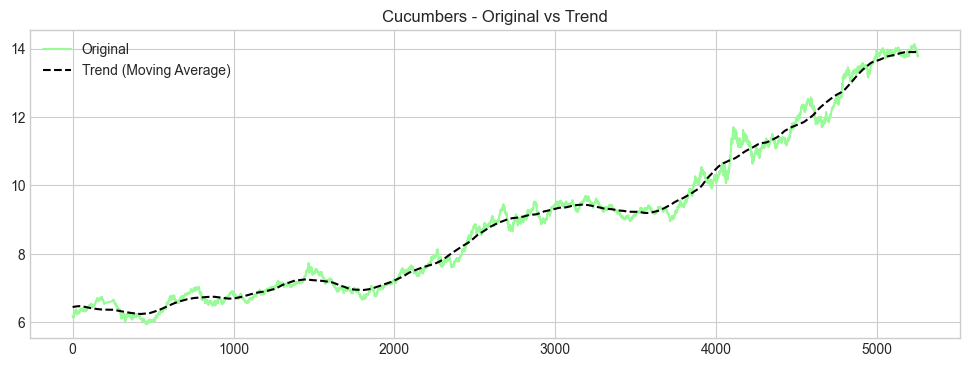

C:\Users\Wal_S\AppData\Local\Temp\ipykernel_31608\2362703215.py:5: RuntimeWarning: divide by zero encountered in divide
  periods = 1 / f


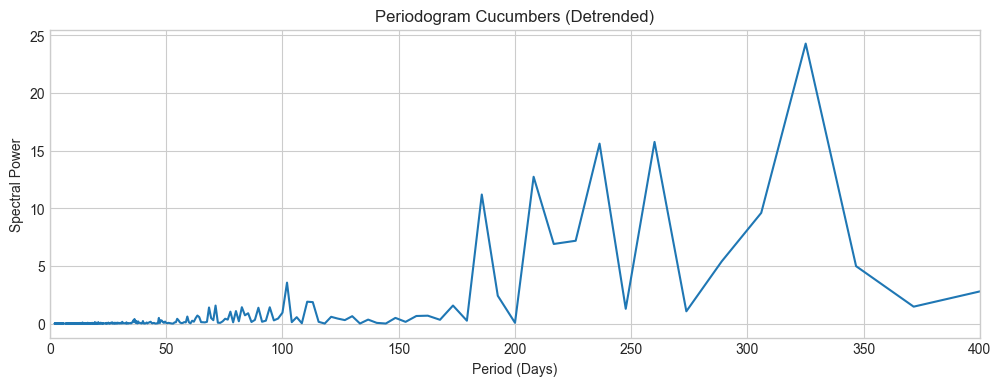

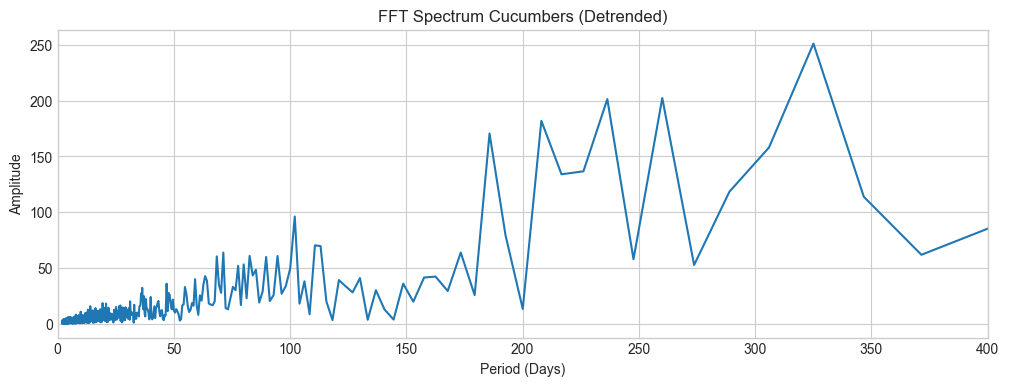


MANUAL DETREND + SPECTRAL ANALYSIS: GUITARS


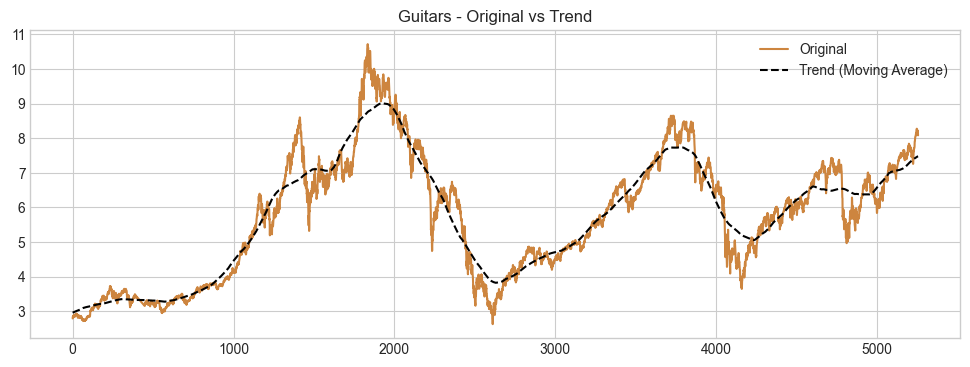

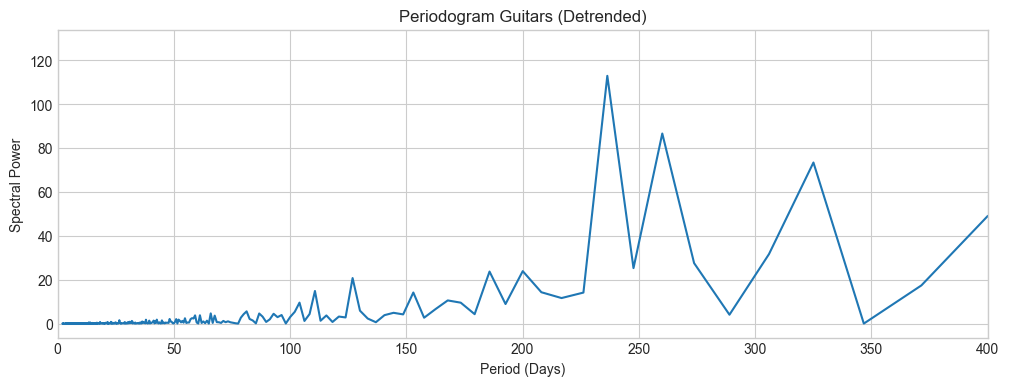

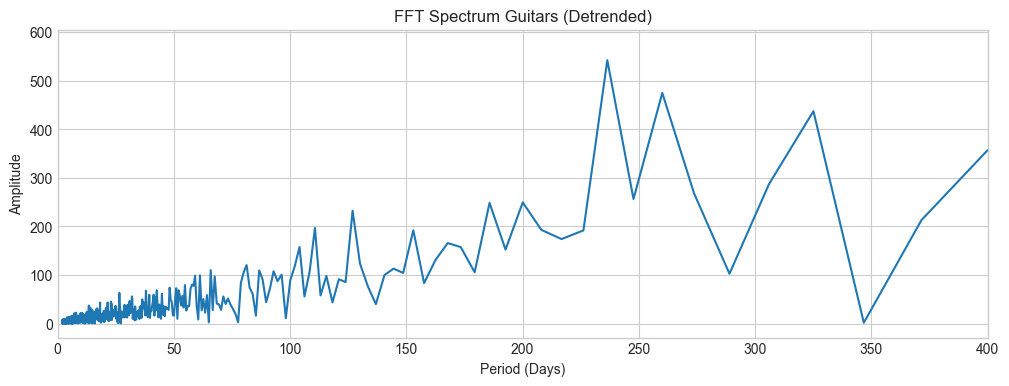


MANUAL DETREND + SPECTRAL ANALYSIS: SLINGSHOTS


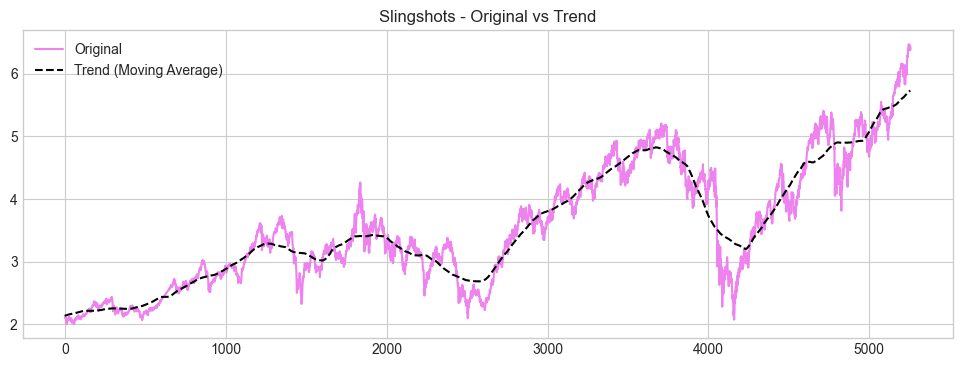

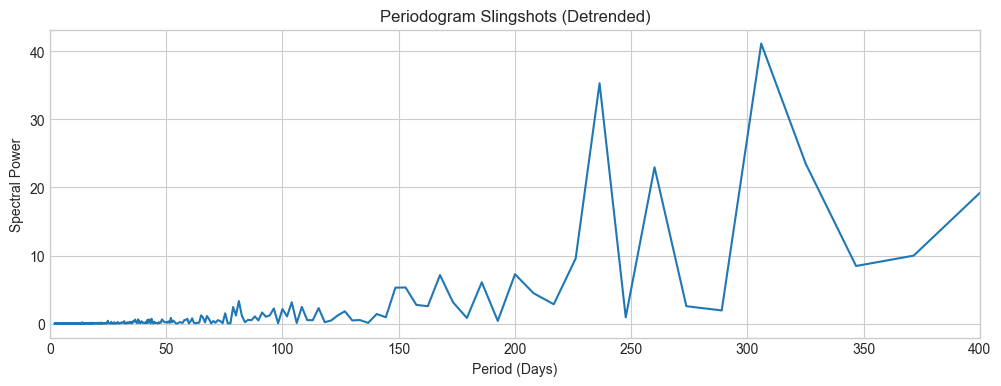

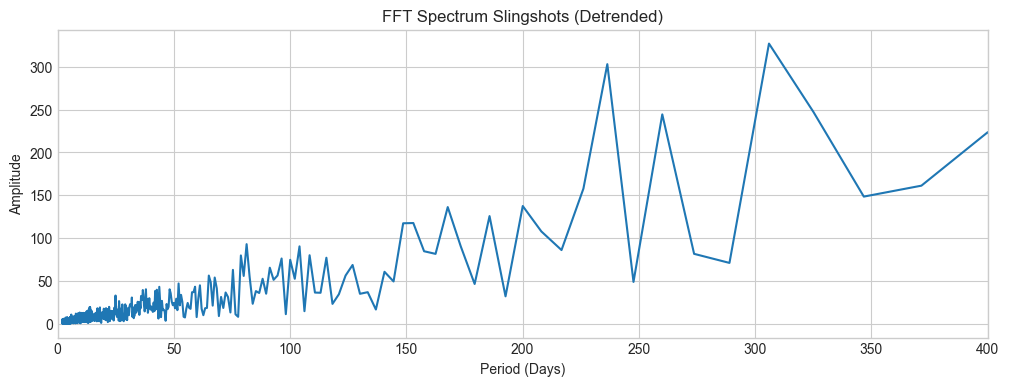


MANUAL DETREND + SPECTRAL ANALYSIS: STOCKS


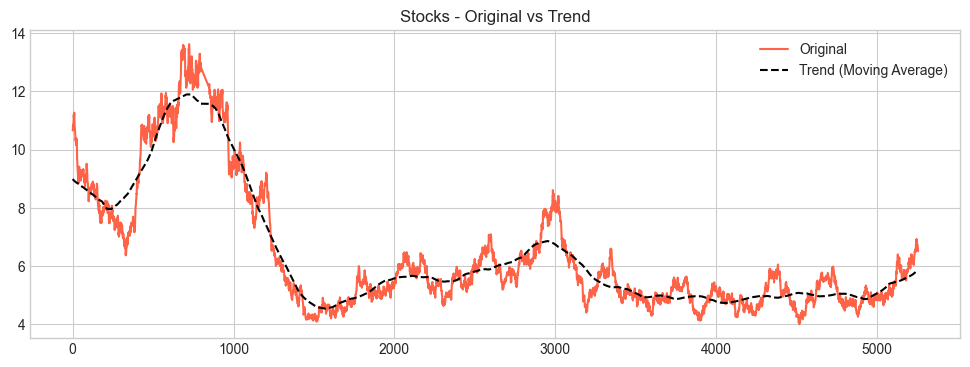

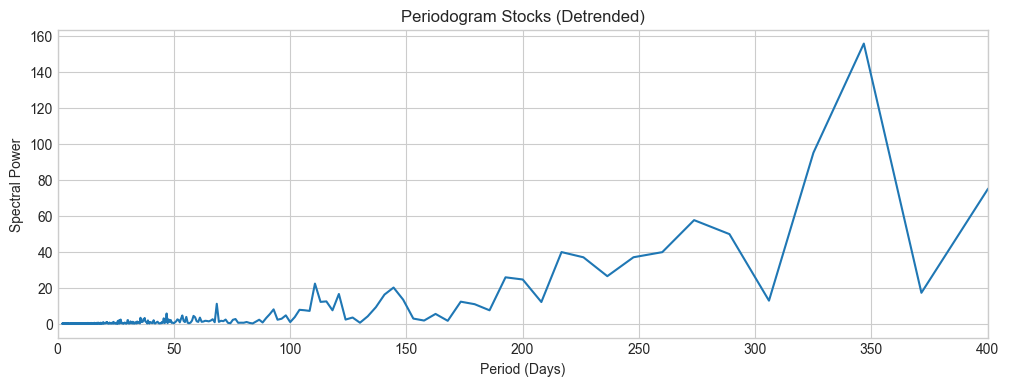

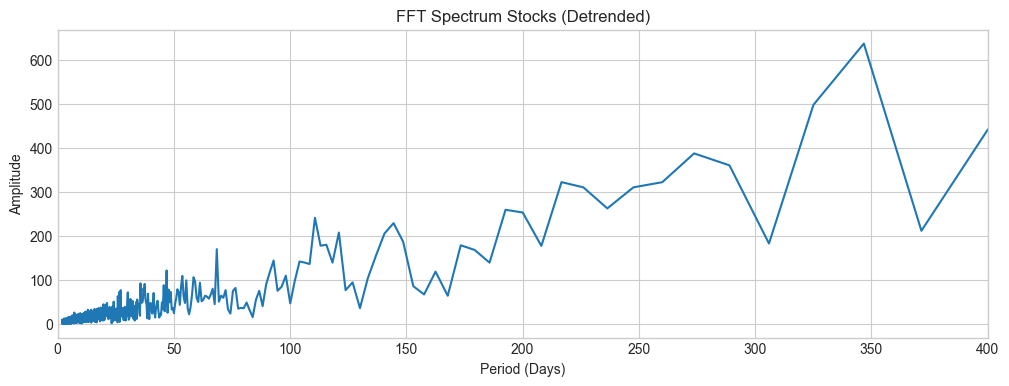


MANUAL DETREND + SPECTRAL ANALYSIS: SUGAR


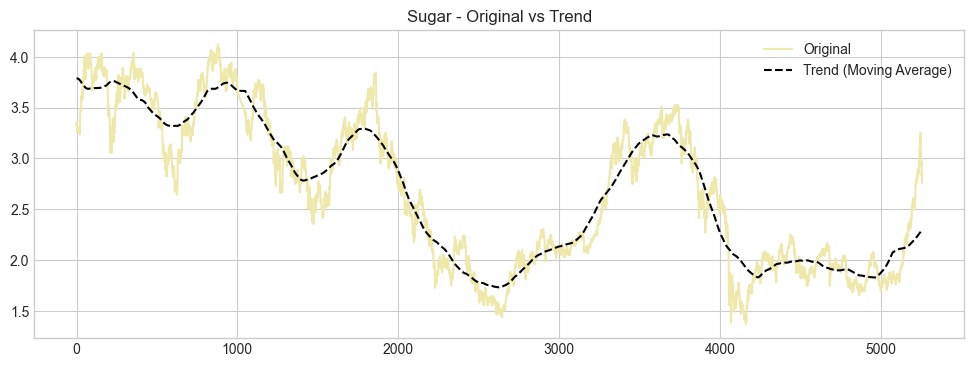

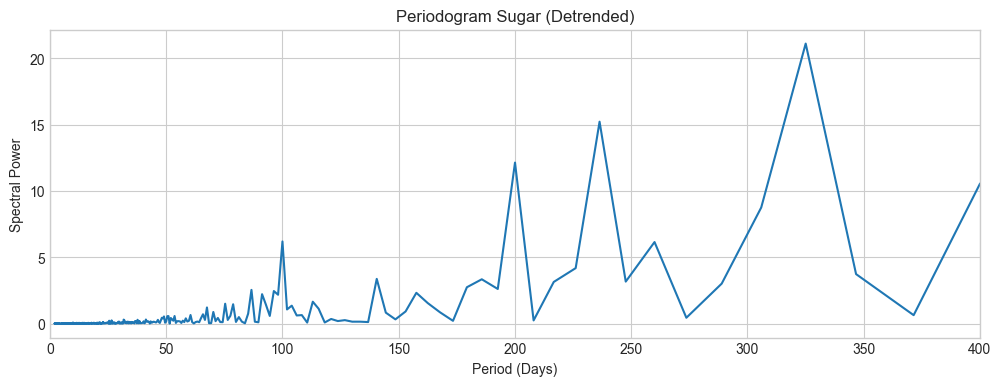

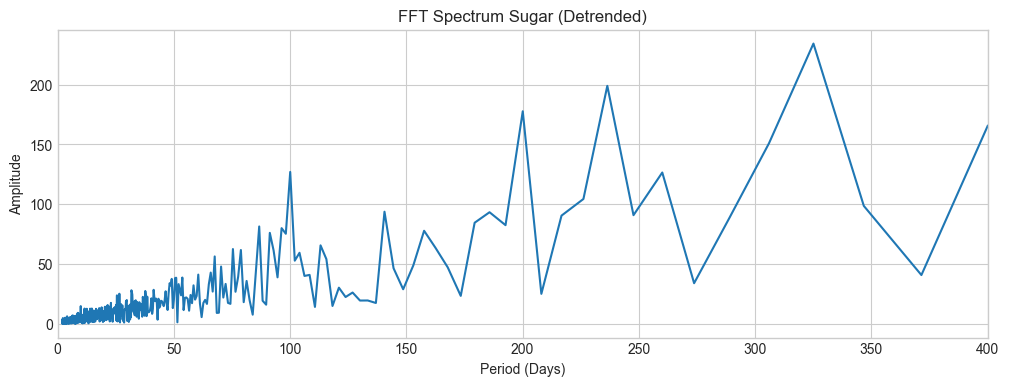


MANUAL DETREND + SPECTRAL ANALYSIS: WATER


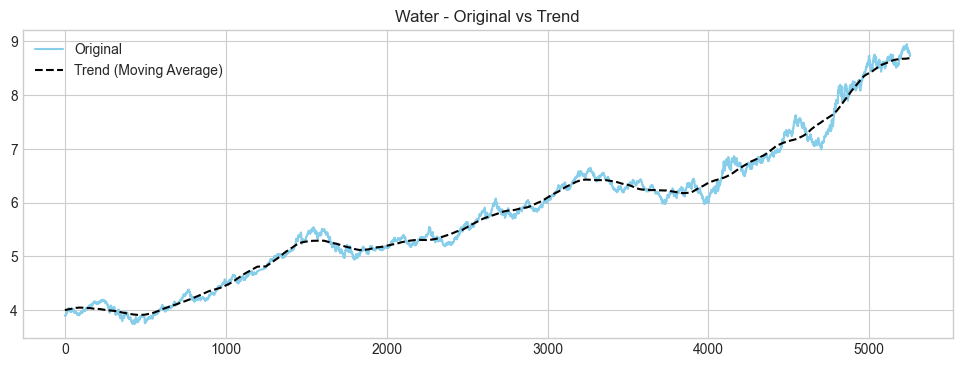

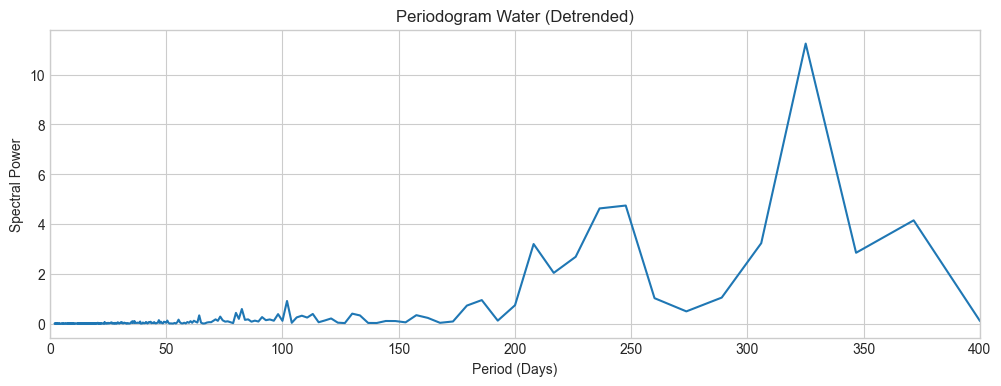

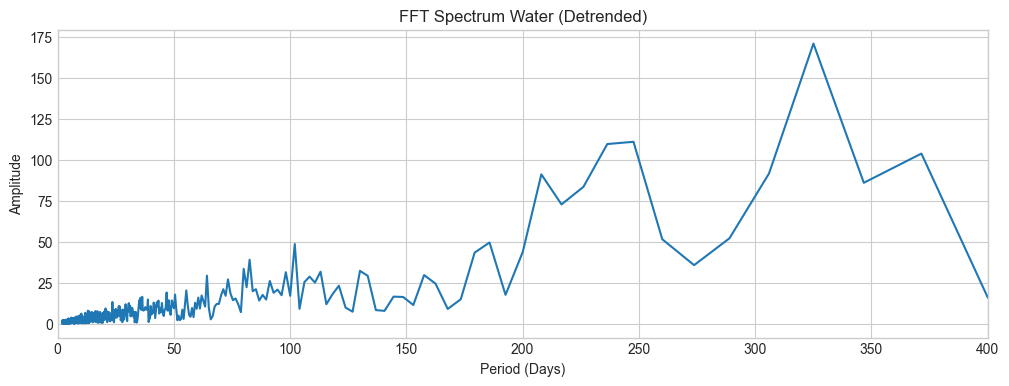


MANUAL DETREND + SPECTRAL ANALYSIS: TRANQUILLITY


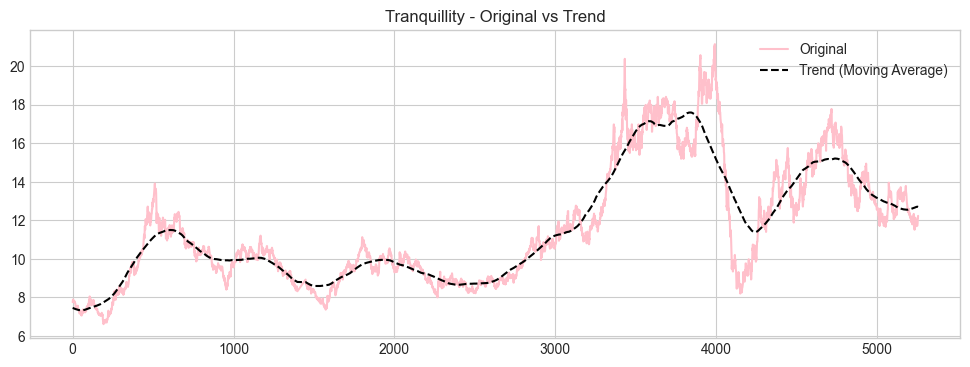

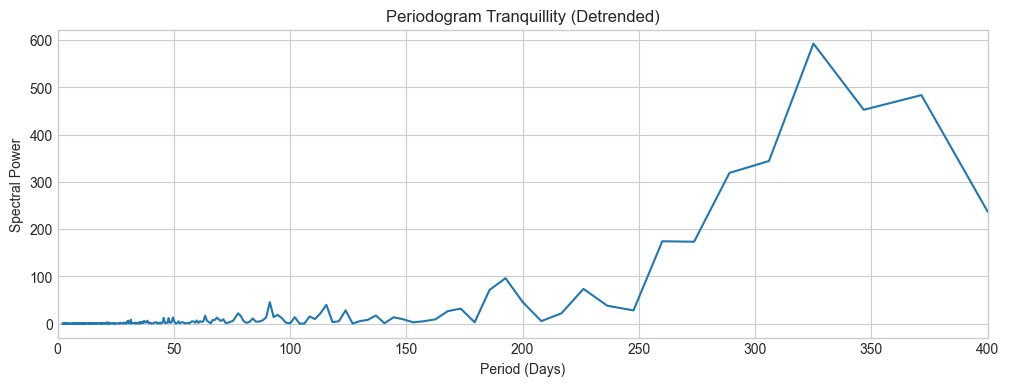

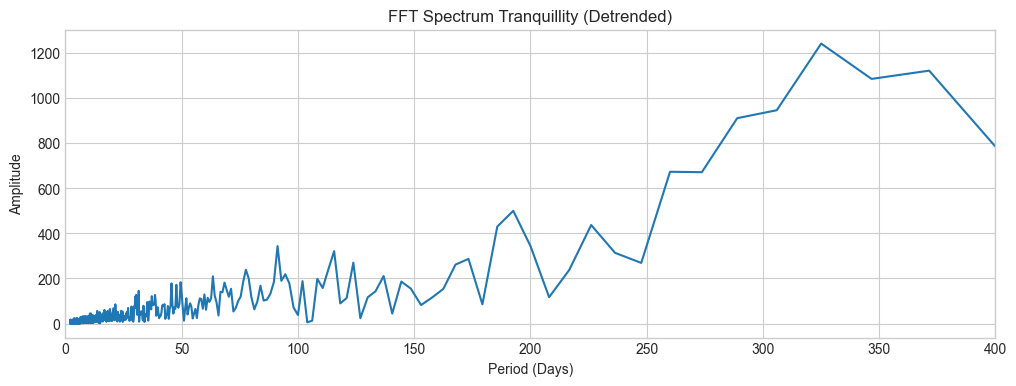

In [ ]:
# Choose detrend window (start with 365 days as rough guess)
#This can be ignored. pipeline does nothing useful from here on
detrend_window = 365

for column, color in colours.items():
    print(f"\n{'='*60}\nMANUAL DETREND + SPECTRAL ANALYSIS: {column.upper()}\n{'='*60}")
    
    series = df[column].dropna()

    # Manual detrend
    detrended, trend = manual_detrend(series, window=detrend_window)
    
    # Plot original vs trend
    plt.figure(figsize=(12, 4))
    plt.plot(series, label='Original', color=color)
    plt.plot(trend, label='Trend (Moving Average)', linestyle='--', color='black')
    plt.title(f'{column.capitalize()} - Original vs Trend')
    plt.legend()
    plt.show()

    # Periodogram
    plot_periodogram(detrended, title=f"{column.capitalize()} (Detrended)")

    # FFT spectrum (optional cross-check)
    plot_fft(detrended, title=f"{column.capitalize()} (Detrended)")
